# ASHviz: stdViz.R
This initial Jupyter notebook of ggplot charts explores visualizations of session activity over time, usually as Average Active Sessions (AAS), and broken down by wait class or other dimensions.

First a couple of lines to control plotting dimensions:

In [1]:
library(repr)
options(repr.plot.width = 7, repr.plot.height = 4.5)

## Install ashdat and ggplot
The `ashdat` R package contains a data frame prepared from the ASH dumps that my R scripts referenced. The Jupyter notebooks all import this same data frame as `ashDF`

The `dplyr` package is useful for data reduction / ETL pipelines

And of course we need `ggplot2`. 

I'm not worried about the warning messages, they sound innocuous enough to ignore for now.

In [2]:
# install ashdat from current directory
install.packages("./ashdat_0.1.0.tar.gz", repos = NULL)

library(ashdat)
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## ASHDUMP1 data frame
In my original `Setup.R` script, `ashDF` is the name of the ASH dump data frame used to develop the plots. We maximize re-usability of that code by initializing data frame `ashDF` with `ashdat::ASHDUMP1`

In [3]:
ashDF <- ashdat::ASHDUMP1
str(ashDF)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	214204 obs. of  36 variables:
 $ DBID                    : Factor w/ 1 level "3500743502": 1 1 1 1 1 1 1 1 1 1 ...
 $ INSTANCE_NUMBER         : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 1 1 1 1 1 ...
 $ SAMPLE_ID               : int  35545015 35545015 35545015 35545015 35545015 35545015 35545015 35545015 35545015 35545015 ...
 $ SAMPLE_TIME             : POSIXct, format: "2006-10-09 12:19:24" "2006-10-09 12:19:24" ...
 $ SESSION_ID              : Factor w/ 620 levels "1522","1526",..: 22 39 75 83 92 111 120 137 163 234 ...
 $ SESSION_SERIAL.         : Factor w/ 1391 levels "1","3","4","5",..: 16 494 791 222 13 616 706 66 92 11 ...
 $ USER_ID                 : Factor w/ 6 levels "0","5","24","55",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ SQL_ID                  : Factor w/ 1189 levels "","0486hsh0p6hcm",..: 380 243 238 222 243 222 380 222 111 243 ...
 $ SQL_CHILD_NUMBER        : Factor w/ 39 levels "0","1","2","3",..: 2 4 3 1 4 1 2 1 1 4 ...
 $ SQL_PLA

Bingo, we have a nicely manicured data frame of the original ASH dump data, handed to us through the ashdat package. Over 200,000 observations from 4 RAC instances with microsecond time stamps! Note that all columns are marked as factors, with the exception of dates, timers, EST_COUNT and SAMPLE_ID.
Most of the columns are straight from ASH, but some important additions are:
- EST_COUNT : this is the estimated event count based on measured sample latency (assuming default 1000ms sampling interval)
- STATE: either CPU, WAIT or I/O to draw the basic three-state perf chart
- STATE_CLASS: either CPU or the WAITCLASS name for classic perf page decomposition
- MINIT: SAMPLE_TIME truncated to the minute

The above sequence of package loading / attaching and creation of the ashDF data frame are common across notebooks that use the ashdat package for data. 

## Sampled Session Activity over Time

### summarize ashDF
The following data frame is a summary of ashDF with the total number of active sessions (AS) broken out by instance, sample time and wait state/class. 

In [4]:
d <- ashDF %>% group_by( INSTANCE_NUMBER, SAMPLE_TIME, STATE_CLASS) %>% summarize( AS = n() )

### geom_point ( )
Using the `SAMPLE_TIME` for x and AS (Active Sessions) for y we color by `WAITCLASS` and plot points for every distinct sample time and wait class. Note that since ASH samplers are independent across instances the set of sample times will be distinct. This chart has one point per wait class per sample, and these are independently plotted so there is much overplotting. Setting `alpha = 0.5` does not really help.

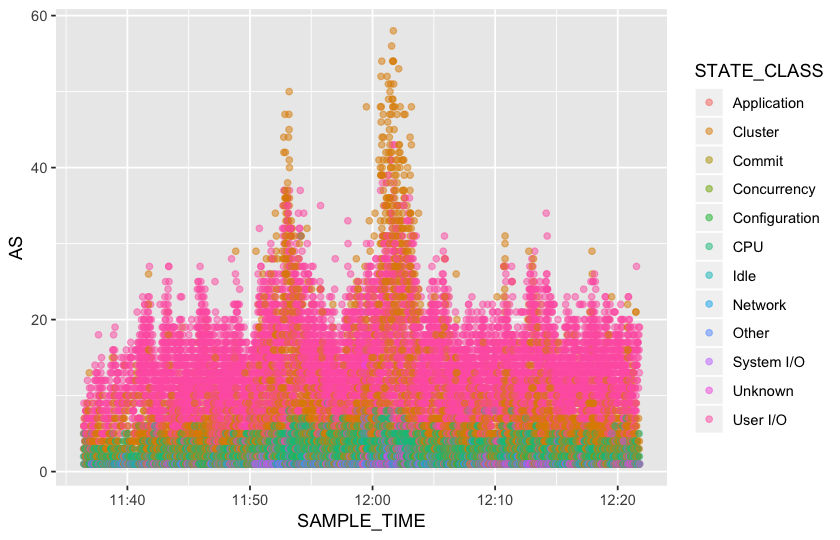

In [5]:
p <- ggplot(data = d, aes(x = SAMPLE_TIME, y = AS, color = STATE_CLASS))
p + geom_point(alpha=.5)

The chart above is not particularly effective, although it does give the sense of the DB time being dominated by a couple of wait classes. The massive overplotting obscures any real analysis. 

Reducing the point size to .2 helps some although the picture is not necessarily much clearer. The horizontal striping is a reminder that session counts for each sample are whole numbers, so y values will only be integers.

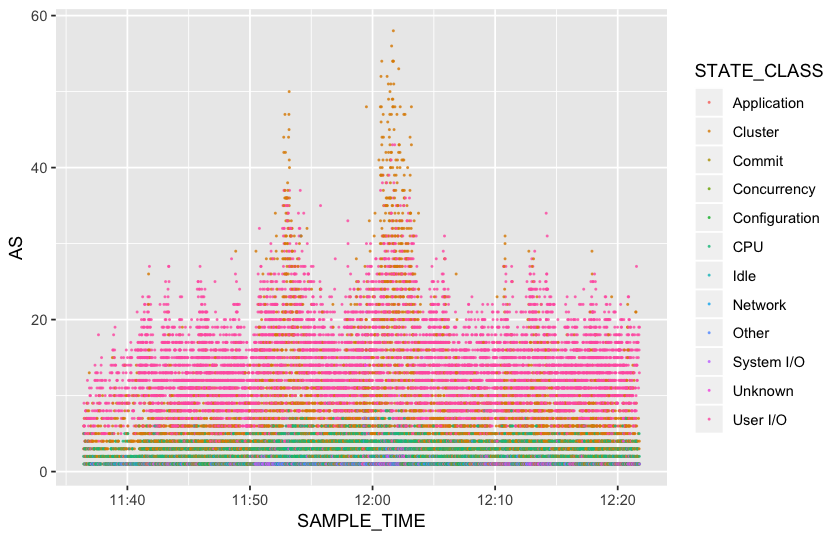

In [6]:
p <- ggplot(data = d, aes(x = SAMPLE_TIME, y = AS, color = STATE_CLASS))
p + geom_point(alpha = 0.7, size = .2)

Warning message:
“Removed 33398 rows containing missing values (geom_point).”

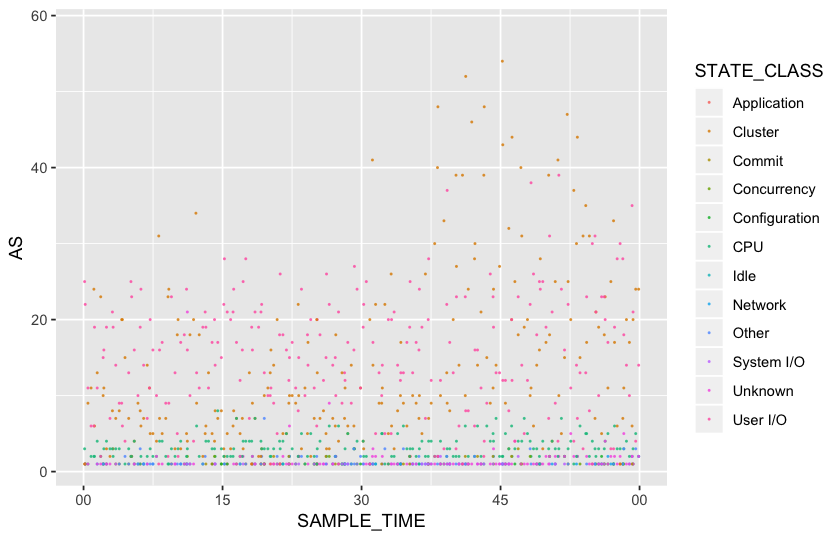

In [7]:
p <- ggplot(data = d, aes(x = SAMPLE_TIME, y = AS, color = STATE_CLASS))
p + geom_point(alpha = 0.7, size = .2) +
    scale_x_datetime( limits = as.POSIXct(c("2006-10-09 12:00","2006-10-09 12:01") ,format = "%Y-%m-%d %H:%M"))

Zooming in still further by specifying the 10-second interval from 12:00:00 to 12:00:10:

Warning message:
“Removed 34279 rows containing missing values (geom_point).”

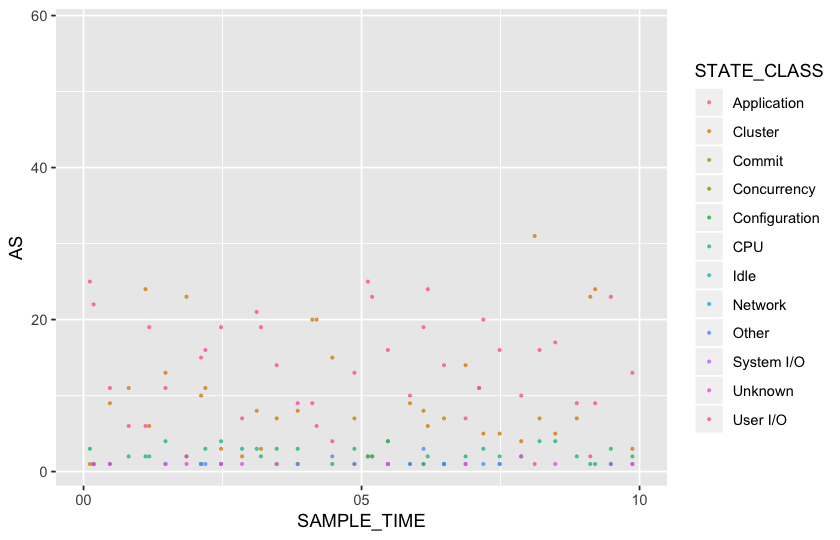

In [8]:
p <- ggplot(data = d, aes(x = SAMPLE_TIME, y = AS, color = STATE_CLASS))
p + geom_point(alpha = 0.7, size = .5) +
    scale_x_datetime( limits = as.POSIXct(c("2006-10-09 12:00:00","2006-10-09 12:00:10") 
                                           ,format = "%Y-%m-%d %H:%M:%S"))

OK, so not very informative, but we got to the bottom of the overplotting which is indeed the many x-values corresponding to independent streams of sampler times. So this is the big mistake with this initial investigation: aggregating over the y-dimension (`STATE_CLASS`) but not over the x-dimension (`SAMPLE_TIME`) and producing a big swarm of independent points in close proximity to each other.

Perhaps the most useful aspect of these last two plots was getting `scale_x_datetime( )` to work properly.

## Average Active Sessions (AAS) by Minute
`ashDF` has a column `MINIT` that is the `SAMPLE_TIME` truncated to the minute. We can aggregate all samples by minute and compute the Average Active Sessions for that minute by `STATE_CLASS`.

Create a data frame grouping by `MINIT` and `STATE_CLASS` and computing: `AAS = n()/60`.

AAS is total samples divided by 60 assuming default sampling interval of 1000 ms (= 1 sec):
* seconds / 60 = minutes
* minutes / minutes = AAS 

In [9]:
d2 <- ashDF %>% group_by( MINIT, STATE_CLASS) %>% summarize( AAS = n()/60)

## geom_line( )
Using `x = MINIT` and `y = AAS` for aesthetic mappings we color by `WAITCLASS` and use `geom_line` for the geometry:

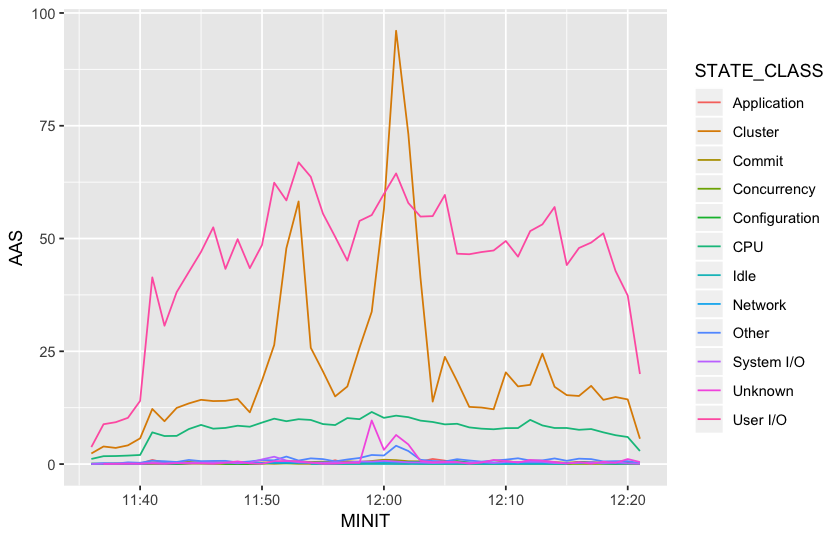

In [10]:
# set up plot aesthetics
p <- ggplot(data = d2, aes(x = MINIT, y=AAS, color = STATE_CLASS))
# add geom to plot
p + geom_line()

The chart above is interesting and informative. We can clearly showing activity apikes in a single wait class: Cluster. Almost all of the other activity is either User I/O or CPU, with the exception of an interesting blip in a couple of classes right around 12:00. Normalized aggregation also gives better insight into total workload, note the change in y-axis range from earlier plots.

Faceting by `INSTANCE_NUMBER` may reveal whether the spikes in Cluster wait activity were specific to instances or cluster-wide. In this case the spikes seem quite equally shared across the instances.

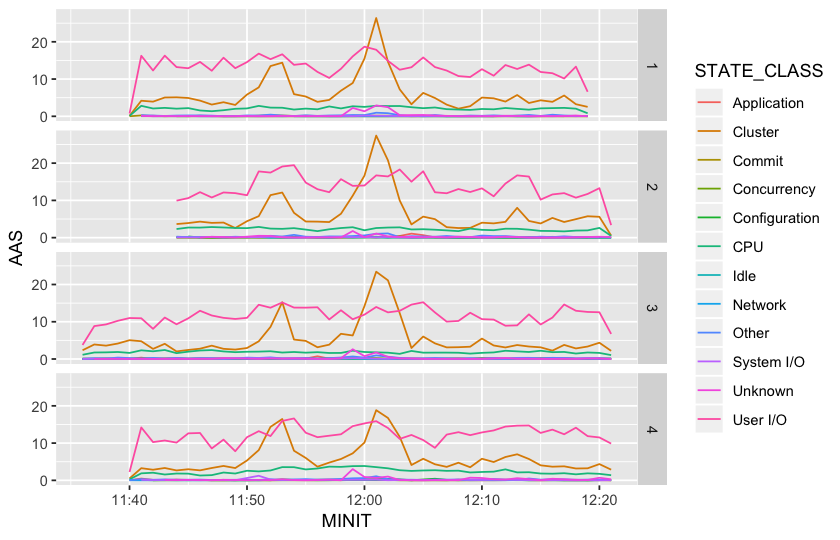

In [11]:
# set up instance, minit, waitclass 
d3 <- ashDF %>% group_by(INSTANCE_NUMBER, MINIT, STATE_CLASS) %>% summarize(AAS = n()/60)
# use d and chart AAS by minute for each wait class
p <- ggplot(data = d3, aes(x = MINIT, y=AAS, color = STATE_CLASS))
# use lines and facet by instance
p + geom_line() + facet_grid( INSTANCE_NUMBER ~. )

The plot above also evidences good workload sharing across the RAC instances, as activity levels in all the wait classes are very closely matched. 

We can reverse the roles of `WAITCLASS` and `INSTANCE`, faceting by the former and coloring by the latter:

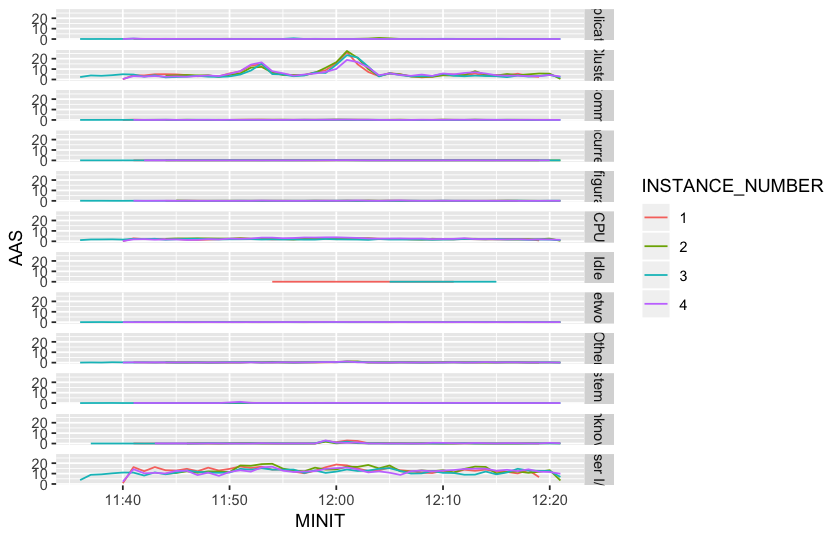

In [12]:
p <- ggplot(data = d3, aes(x = MINIT, y=AAS, color = INSTANCE_NUMBER))
# use lines and facet by instance
p + geom_line() + facet_grid( STATE_CLASS ~. )

The vertical "squashing" flatlines all classes except Cluster and User I/O. Instance coloring is rendered useless by overplotting. Fail.

Using `scales = "free"` we can allow each facet (class) y-axis to scale independently. This shows differences across instances within class pretty well, but the relative unimportance of low activity classes is sacrificed and potentially misleading.

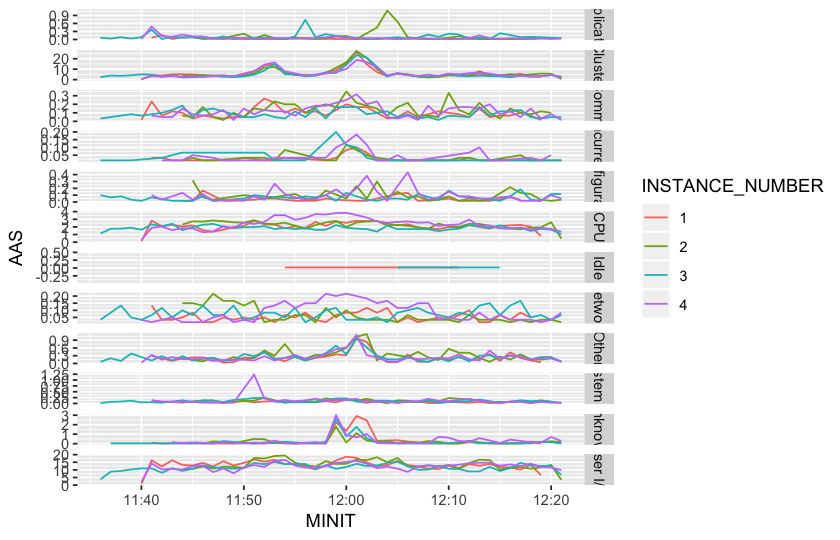

In [13]:
p + geom_line() + 
  facet_grid( STATE_CLASS ~. ,scales = "free" )

## Classic Perf Chart: CPU, I/O, WAIT by MINIT
We will create the classic stacked activity chart showing Average Active Sessions in CPU, I/O and WAIT summarized over 1-minute time intervals.

First, summarize `ashDF` by `MINIT` and `STATE`, computing `AAS`:

In [14]:
d4 <- ashDF %>% group_by(MINIT, STATE) %>% summarize(AAS = n()/60)

## geom_area ( )

Using `geom_area( )` to plot `AAS` by `STATE` over time in minutes:

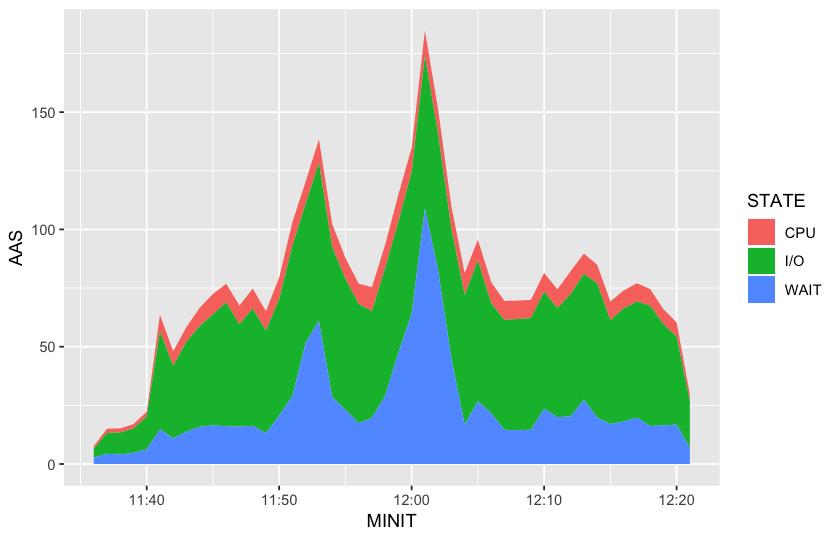

In [15]:
p <- ggplot(d4, aes(x = MINIT, y = AAS, fill = STATE))
#
p + geom_area()

This is the thumbnail version of the classic EM Activity Chart, with a couple of issues:
* Colors mismatched: CPU should be green, I/O blue, WAIT red
* Stacking order wrong: should be CPU bottom, I/O middle, WAIT top

We can adjust the colors using a state-color mapping vector and passing it to `scale_fill_manual`.

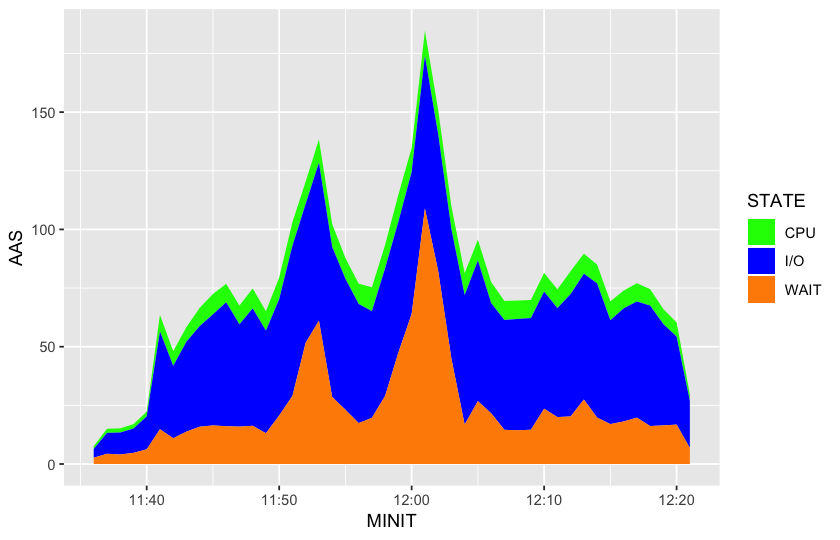

In [16]:
# use more standard colors for CPU, I/O and WAIT
statecolors <- c("CPU" = "green", "I/O" = "blue", "WAIT" = "dark orange")
# re-initialize plot
p <- ggplot(d4, aes(x = MINIT, y = AAS, fill = STATE))
# plot with new colors for state
p + geom_area() + scale_fill_manual( values = statecolors )

Finally we can re-order the `STATE` factor levels and stack the areas in the desired order to get something closely resembling the classic DB Activity chart.

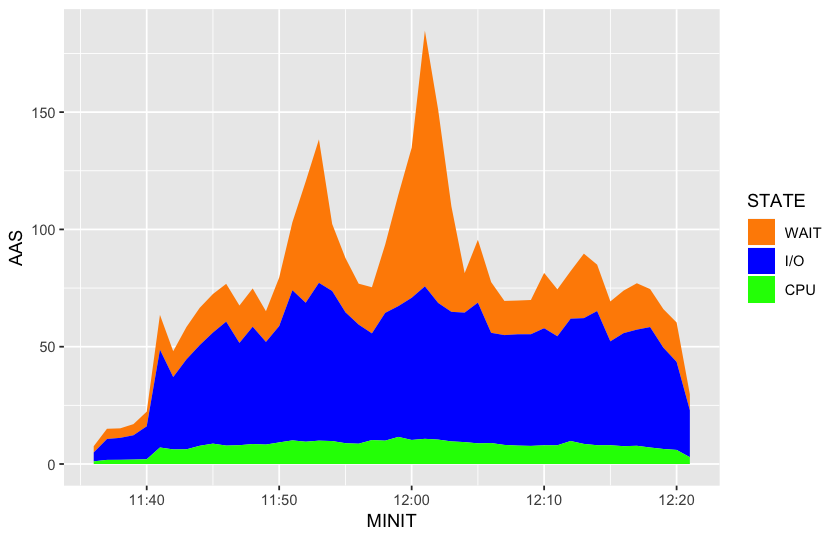

In [17]:
# re-order STATE factor
d4$STATE <- factor( d4$STATE, levels = c("WAIT", "I/O", "CPU") )
#
# re-initialize plot with new levels
p <- ggplot(d4, aes(x = MINIT, y = AAS, fill = STATE))
#
p + geom_area() + scale_fill_manual( values = statecolors )

## SAMPLE_ID vs SAMPLE_TIME
Initial experiments using `geom_point( )` used the `SAMPLE_ID` instead of `SAMPLE_TIME` for the x-axis, with some at first confusing results. Here is an example:

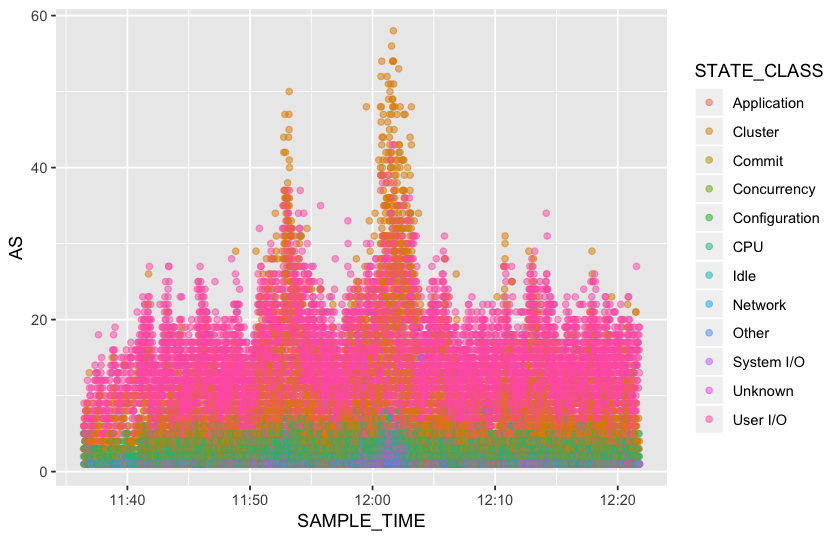

In [18]:
ggplot(data = ashDF %>% group_by( SAMPLE_TIME, STATE_CLASS ) %>% summarize (AS = n() )
      ,aes( x = SAMPLE_TIME, y = AS, color = STATE_CLASS)) +  
      geom_point(alpha=.5)

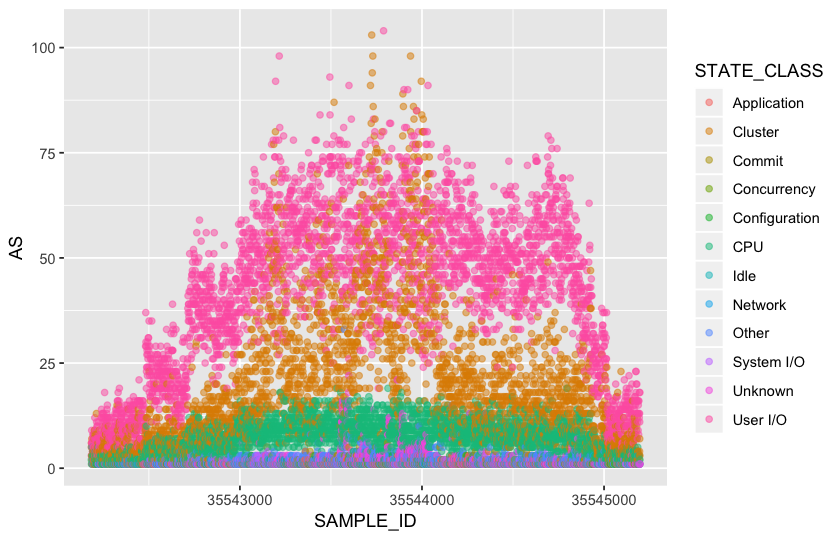

In [19]:
ggplot(data = ashDF %>% group_by( SAMPLE_ID, STATE_CLASS ) %>% summarize (AS = n() )
      ,aes( x = SAMPLE_ID, y = AS, color = STATE_CLASS)) +  
      geom_point(alpha=.5)

These are two radically different images of what happened over time. The first is pretty well organized, and shows two distinct spikes of increased activity in Cluster wait class. The second is quite disorganized and without clear features, and spans a much greater range in the y-axis (AS = active sessions.)

As a rule use `SAMPLE_TIME` rather than `SAMPLE_ID` for ASH visualization time axes.

Coloring the `SAMPLE_ID` version by `INSTANCE_NUMBER` shows some structure as there appear to be pairs of activity spikes: 1 & 2 together, and 3 & 4 together.

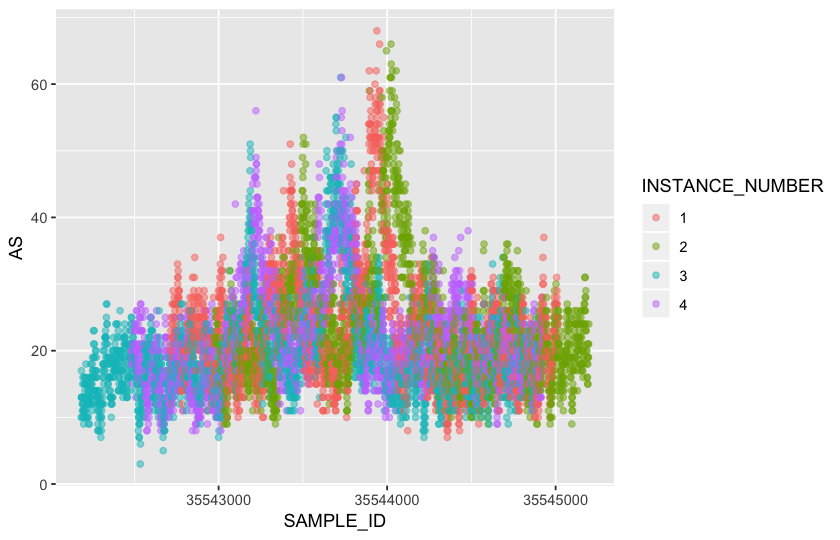

In [20]:
ggplot(data = ashDF %>% group_by(SAMPLE_ID, INSTANCE_NUMBER) %>% summarize(AS = n())
      ,aes(x = SAMPLE_ID, y = AS, color = INSTANCE_NUMBER)) +  
  geom_point(alpha=.5)

The source of this apparent confusion is the fact that ASH samplers in RAC work independently and generate unique `SAMPLE_TIME` streams, however the `SAMPLE_ID` streams overlap closely in time. Aggregating by `SAMPLE_ID` can give a distorted view of activity over time.

I plotted the relationship of `SAMPLE_ID` to `SAMPLE_TIME` for each of the 4 instances using a simple line chart.

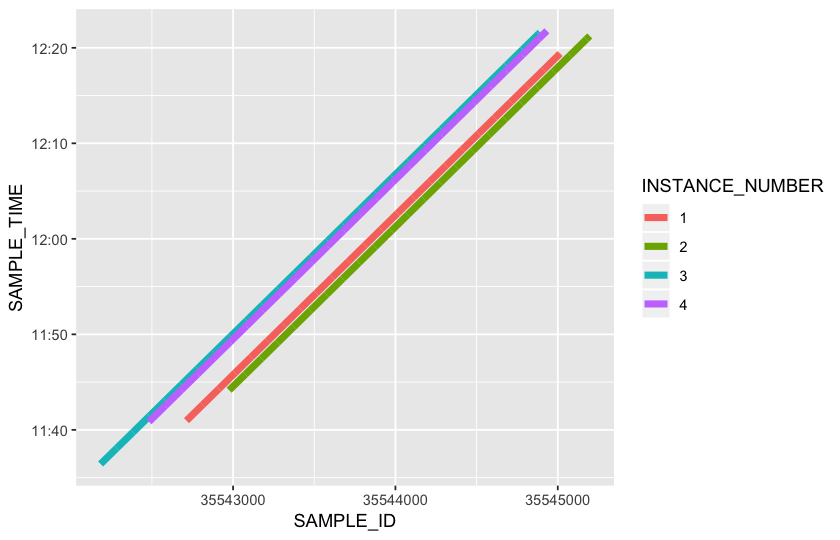

In [21]:
ggplot( data = ashDF %>% distinct(INSTANCE_NUMBER, SAMPLE_ID, SAMPLE_TIME)
       ,aes(x = SAMPLE_ID, y = SAMPLE_TIME, color = INSTANCE_NUMBER)) + 
       geom_line(size=2)

Oops, used `SAMPLE_ID` instead of `SAMPLE_TIME` for the x=axis...better fix.

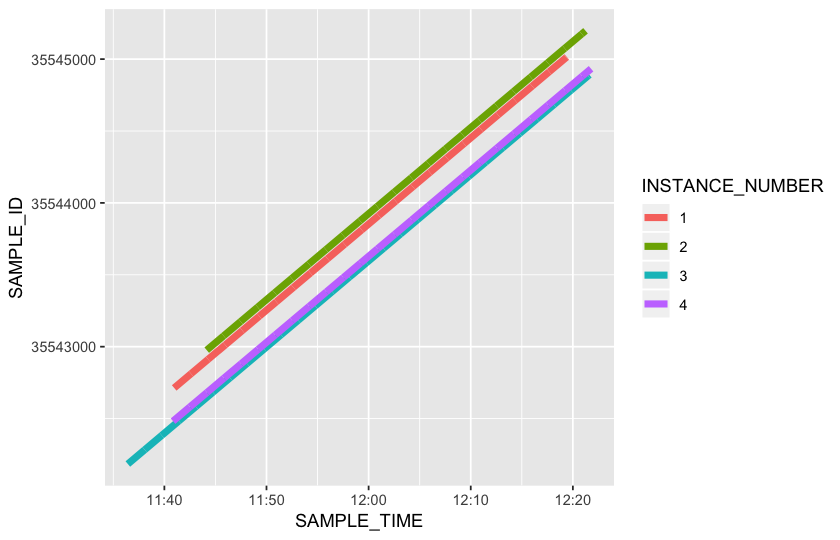

In [22]:
ggplot( data = ashDF %>% distinct(INSTANCE_NUMBER, SAMPLE_ID, SAMPLE_TIME)
       ,aes(y = SAMPLE_ID, x = SAMPLE_TIME, color = INSTANCE_NUMBER)) + 
       geom_line(size=2)

This simple plot is surprisingly informative. We see why the instances spiked together in pairs. Lines close to each other in this chart indicate instances whose `SAMPLE_ID`s and `SAMPLE_TIME`s match closely. Also note that the last `SAMPLE_TIME` of instance 1 precedes that of the other instances by several minutes. Perhaps the ASH dump was triggered from this instance and finished earlier?

Finally, there is a sizeable gap of some 500 `SAMPLE_ID`s between the instance {1,2} group and the {3,4} group. Perhaps this indicates differences in instance (and hence ASH sampler) startup times (?)

## The DB Performance Page
We can use `geom_col( )` and to plot stacked bar chart of total DB activity by wait class over 1-minute intervals, which is essentially the classic DB Performance Page view of the world. I'm not going to bother matching the wait class colors though, not worth the effort here.  

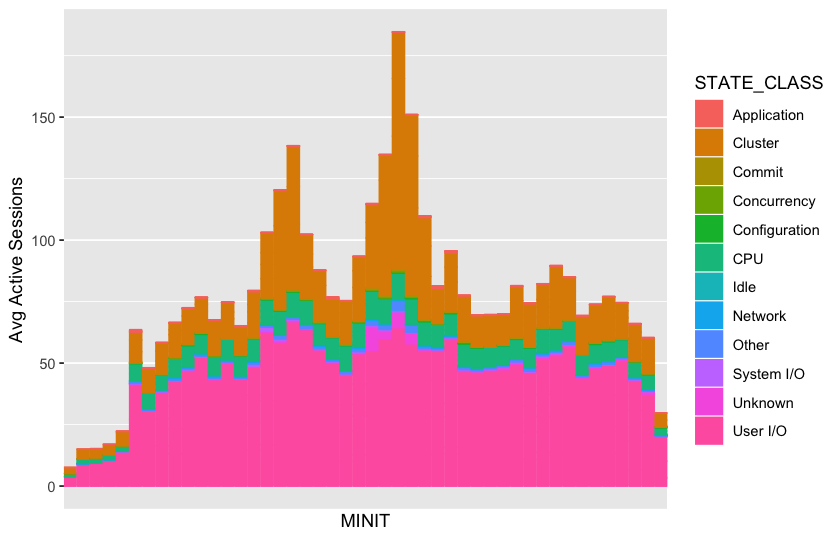

In [25]:
## create one-minute summaries of AAS by WAITCLASS and INSTANCE
d3 <- ashDF %>% 
      group_by(INSTANCE_NUMBER,MINIT,STATE_CLASS) %>% 
      summarize(AAS = n()/60 ) 

# plot global AAS by WAITCLASS per minute
ggplot(data=d3,aes(x=MINIT,y=AAS,color=STATE_CLASS)) + 
     geom_col(aes(fill=STATE_CLASS)) +
     scale_x_discrete(labels = NULL) + ylab("Avg Active Sessions")

# Learnings
- `install.packages( )`
- `dplyr::%>%`
- `geom_point( )`
- `scale_x_datetime( )`
- `geom_area( )`
- `geom_line( )`
- `geom_col( )`
- faceting, colors, `alpha`, `size`
- computing AAS